In [1]:
import pandas as pd
import numpy as np
import tweepy
import json
import io
from skimage import io
import requests
from timeit import default_timer as timer
import os
import matplotlib.pyplot as plt

# Gathering data

In [2]:
# Loading twitter-archive-enhanced.csv File

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive = twitter_archive.sort_values(by=['tweet_id'])
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2355 to 0
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
# Loading image-predictions.tsv

image_predictions = pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', sep='\t')
image_predictions = image_predictions.sort_values(by=['tweet_id'])
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# Storing it locally

image_predictions.to_csv('image_predictions.tsv', index=False)

In [6]:
#Setup for tweepy to get twitter data

consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
#getting all tweet IDs from twitter-archive-enhanced.csv file

tweet_ids = twitter_archive['tweet_id'].values
print(tweet_ids.shape)

(2356,)


In [8]:
# Get a JSON for each tweet ID in twitter-archive-enhanced.csv
errors = {}
t1 = timer()
with open('tweet_json.txt', 'w') as outfile:
    print('Don\'t worry I\'m working on it... It many take some time')
    outfile.write('[')
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write(',')
        except tweepy.TweepError as e:
            errors[tweet_id] = e
    outfile.seek(outfile.tell() - 1, os.SEEK_SET) #Remove thel last ',' that we added as there are no more JSONs.
    outfile.write(']')

t2 = timer()
print('DONE! :)')
print('This Took ' + str(t2 - t1) + ' Seconds')
print(len(errors))

Don't worry I'm working on it... It many take some time


Rate limit reached. Sleeping for: 188
Rate limit reached. Sleeping for: 196


DONE! :)
This Took 2223.0812023999997 Seconds
27


In [9]:
#Read tweets from JSON file

tweet_json = pd.read_json('tweet_json.txt')

# Assessing data

In [10]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2355 to 0
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twitter_archive['name'].value_counts() #Duplicated Names

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Billl        1
Dale         1
Mojo         1
Rose         1
Noah         1
Name: name, Length: 957, dtype: int64

In [13]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [14]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [16]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 168.2+ KB


In [17]:
image_predictions[image_predictions['jpg_url'].duplicated() == True].sort_values(['jpg_url']) #Duplicated URLs

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1864,842892208864923648,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1703,817181837579653120,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,True,Tibetan_terrier,0.295690,True,otterhound,0.036251,True
1858,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.336200,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True
1718,819015337530290176,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1727,820446719150292993,https://pbs.twimg.com/media/CxqsX-8XUAAEvjD.jpg,3,golden_retriever,0.938048,True,kuvasz,0.025119,True,Labrador_retriever,0.022977,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


In [18]:
tweet_json

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2015-11-15 22:32:08+00:00,666020888022790149,666020888022790144,Here we have a Japanese Irish Setter. Lost eye...,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2326,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2327,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [19]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 32 columns):
created_at                       2329 non-null datetime64[ns, UTC]
id                               2329 non-null int64
id_str                           2329 non-null int64
full_text                        2329 non-null object
truncated                        2329 non-null bool
display_text_range               2329 non-null object
entities                         2329 non-null object
extended_entities                2058 non-null object
source                           2329 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 non-null float64
in_reply_to_screen_name          77 non-null object
user                             2329 non-null object
geo                              0 non-null float64
coordinates                 

### -Quality
##### In twitter-archive-enhanced.csv 
    *we don't need reply tweets that have values in "in_reply_to_status_id" , "retweeted_status_id"...
    *we don't need some columns like "in_reply_to_status_id" , "retweeted_status_id"...
    *source is just coppied HTML
    *dog names like "None" or 'a' should be removed
    *remove URLs from text field
    *remove tweets without pictures
    *timestamp should be datetime format
##### In image_predictions
    *Drop duplicate urls
    *Drop useless columns

##### In tweet_json
    *Drop useless columns

### -Tidiness
##### In twitter-archive-enhanced.csv
    *last 4 columns should be merged (doggo	floofer	pupper	puppo)
##### In image-prediction.tsv
    *merge the last 9 columns

*All tables should be merged.

# Cleaning data

In [20]:
#make copies of the original data

twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

In [21]:
# For the twitter-archive-enhanced.csv File
# we don't need reply tweets that have values in "retweeted_status_id

#CODE: Delete any retweets (Tweets that have a retweet_status_id)
twitter_archive_clean.drop(twitter_archive_clean.loc[twitter_archive_clean['retweeted_status_id'].notnull()].index, inplace=True)

In [22]:
#TEST
print(twitter_archive_clean['retweeted_status_id'].value_counts())

Series([], Name: retweeted_status_id, dtype: int64)


In [23]:
# we don't need some columns like "in_reply_to_status_id" , "retweeted_status_id

#CODE: Drop unused columns like ('in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp')
twitter_archive_clean = twitter_archive_clean.drop(columns=['in_reply_to_status_id',
                                                            'in_reply_to_user_id',
                                                            'retweeted_status_id',
                                                            'retweeted_status_user_id',
                                                            'retweeted_status_timestamp'])

In [24]:
#TEST
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2351,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [25]:
#source is just coppied HTML

#CODE: Renaming the HTML text to what the HTML actually displays
twitter_archive_clean['source'].replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>','Twitter for iPhone',inplace=True)
twitter_archive_clean['source'].replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>','Vine - Make a Scene',inplace=True)
twitter_archive_clean['source'].replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','Twitter Web Client',inplace=True)
twitter_archive_clean['source'].replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>','TweetDeck',inplace=True)

#TEST
print(twitter_archive_clean['source'].value_counts())

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64


In [26]:
# dog names like "None" or 'a' should be removed

#CODE: Fixing the tweets with improper dog names
twitter_archive_clean['name'].replace('None',np.nan,inplace=True)
twitter_archive_clean['name'].replace('a',np.nan,inplace=True)
twitter_archive_clean['name'].replace('the',np.nan,inplace=True)
twitter_archive_clean['name'].replace('an',np.nan,inplace=True)

In [27]:
#TEST
print(twitter_archive_clean['name'].value_counts())

Charlie      11
Lucy         11
Oliver       10
Cooper       10
Penny         9
             ..
William       1
Shawwn        1
Dot           1
Scruffers     1
Noah          1
Name: name, Length: 952, dtype: int64


In [28]:
# remove URLs from text field

#CODE: Removing the URLS from all of the tweet texts and putting them in a separate column
temp = twitter_archive_clean["text"].str.split("https://", n = 1, expand = True)
twitter_archive_clean["new_text"]= temp[0]
twitter_archive_clean["tiny_url"]= temp[1]

#Drop Columns
twitter_archive_clean.drop(columns=["text"], inplace = True)

In [29]:
#TEST
twitter_archive_clean['new_text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 "

In [30]:
# remove tweets without pictures

twitter_archive_clean.dropna()

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_text,tiny_url
2326,666411507551481857,2015-11-17 00:24:19 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/666411507...,2,10,quite,None,None,None,None,This is quite the dog. Gets really excited whe...,t.co/aMCTNWO94t
2325,666418789513326592,2015-11-17 00:53:15 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/666418789...,10,10,Walter,None,None,None,None,This is Walter. He is an Alaskan Terrapin. Lov...,t.co/qXpcwENTvn
2319,666447344410484738,2015-11-17 02:46:43 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/666447344...,9,10,Scout,None,None,None,None,This is Scout. She is a black Downton Abbey. I...,t.co/kH60oka1HW
2318,666454714377183233,2015-11-17 03:16:00 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/666454714...,10,10,Kreggory,None,None,None,None,I'll name the dogs from now on. This is Kreggo...,t.co/uPqPeXAcua
2317,666644823164719104,2015-11-17 15:51:26 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/666644823...,9,10,Jimothy,None,None,None,None,This is Jimothy. He is a Botwanian Gouda. Can ...,t.co/LEkZjZxESQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,This is Franklin. He would like you to stop ca...,t.co/AtUZn91f7f
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,This is Darla. She commenced a snooze mid meal...,t.co/tD36da7qLQ
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,This is Archie. He is a rare Norwegian Pouncin...,t.co/wUnZnhtVJB
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,This is Tilly. She's just checking pup on you....,t.co/0Xxu71qeIV


In [31]:
#Drop columns
twitter_archive_clean = twitter_archive_clean.drop(columns=['expanded_urls'])

In [32]:
#TEST
twitter_archive_clean.head()

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_text,tiny_url
2355,666020888022790149,2015-11-15 22:32:08 +0000,Twitter for iPhone,8,10,NaN,None,None,None,None,Here we have a Japanese Irish Setter. Lost eye...,t.co/BLDqew2Ijj
2354,666029285002620928,2015-11-15 23:05:30 +0000,Twitter for iPhone,7,10,NaN,None,None,None,None,This is a western brown Mitsubishi terrier. Up...,t.co/r7mOb2m0UI
2353,666033412701032449,2015-11-15 23:21:54 +0000,Twitter for iPhone,9,10,NaN,None,None,None,None,Here is a very happy pup. Big fan of well-main...,t.co/y671yMhoiR
2352,666044226329800704,2015-11-16 00:04:52 +0000,Twitter for iPhone,6,10,NaN,None,None,None,None,This is a purebred Piers Morgan. Loves to Netf...,t.co/DWnyCjf2mx
2351,666049248165822465,2015-11-16 00:24:50 +0000,Twitter for iPhone,5,10,NaN,None,None,None,None,Here we have a 1949 1st generation vulpix. Enj...,t.co/4B7cOc1EDq


In [33]:
# clean the last 4 columns should be merged (doggo floofer pupper puppo)

#CODE: Fixing improper use of NULL values
twitter_archive_clean['doggo'].replace('None','',inplace=True)
twitter_archive_clean['floofer'].replace('None','',inplace=True)
twitter_archive_clean['pupper'].replace('None','',inplace=True)
twitter_archive_clean['puppo'].replace('None','',inplace=True)

In [34]:
#Code: Merging the last 4 columns togeather
twitter_archive_clean['dog_type'] = twitter_archive_clean['doggo']+twitter_archive_clean['floofer']+twitter_archive_clean['pupper']+twitter_archive_clean['puppo']
twitter_archive_clean['dog_type'].replace('',np.nan,inplace=True)
twitter_archive_clean = twitter_archive_clean.drop(columns=['doggo','floofer','pupper','puppo'])

In [35]:
#TEST
twitter_archive_clean.sample(20)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,new_text,tiny_url,dog_type
1666,682697186228989953,2015-12-31 22:57:47 +0000,Twitter for iPhone,12,10,NaN,NAAAAAAA ZAPENYAAAAA MABADI-CHIBAWAAA 12/10,t.co/Ny4iM6FDtz,NaN
1366,702671118226825216,2016-02-25 01:47:04 +0000,Twitter for iPhone,10,10,Rambo,Meet Rambo &amp; Kiwi. Rambo's the pup with th...,t.co/MpH1Fe9LhZ,NaN
924,755206590534418437,2016-07-19 01:04:16 +0000,Twitter for iPhone,14,10,one,This is one of the most inspirational stories ...,t.co/I5ld3eKD5k,doggo
2148,669749430875258880,2015-11-26 05:28:02 +0000,Twitter for iPhone,8,10,Clarence,Say hello to Clarence. Clarence thought he saw...,t.co/tbFaTUHLJB,NaN
1315,706681918348251136,2016-03-07 03:24:33 +0000,Twitter for iPhone,12,10,Katie,Say hello to Katie. She's a Mitsubishi Hufflep...,t.co/CFPIcGcwJv,NaN
1740,679503373272485890,2015-12-23 03:26:43 +0000,Twitter for iPhone,8,10,Dwight,This is Dwight. He's a pointy pupper. Very doc...,t.co/jjW7zTxY9Z,pupper
473,816336735214911488,2017-01-03 17:33:39 +0000,Twitter for iPhone,11,10,Dudley,This is Dudley. He found a flower and now he's...,t.co/nuJxtmlLcY,NaN
1904,674632714662858753,2015-12-09 16:52:27 +0000,Twitter for iPhone,5,10,NaN,Rare submerged pup here. Holds breath for a lo...,t.co/EJzzNHE8bE,NaN
2160,669567591774625800,2015-11-25 17:25:28 +0000,Twitter for iPhone,9,10,Kollin,Meet Kollin. He's a Parakeetian Badminton from...,t.co/XPLB3eoXiX,NaN
335,832645525019123713,2017-02-17 17:38:57 +0000,Twitter Web Client,10,10,not,There's going to be a dog terminal at JFK Airp...,t.co/dp5h9bCwU7,NaN


In [36]:
# Timestamp into date & Time

#CODE: Fixing timestamp field to become a datetime value
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

In [37]:
#TEST
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 2355 to 0
Data columns (total 9 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns, UTC]
source                2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  1426 non-null object
new_text              2175 non-null object
tiny_url              2117 non-null object
dog_type              344 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 249.9+ KB


In [38]:
#CODE: Fix tweet_id to int
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype('int64')

In [39]:
#TEST
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 2355 to 0
Data columns (total 9 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns, UTC]
source                2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  1426 non-null object
new_text              2175 non-null object
tiny_url              2117 non-null object
dog_type              344 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 249.9+ KB


In [40]:
#TEST
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,new_text,tiny_url,dog_type
249,845306882940190720,2017-03-24 16:10:40+00:00,Twitter for iPhone,12,10,Pickles,This is Pickles. She's a silly pupper. Thinks ...,t.co/7mPCF4ZwEk,pupper
1680,682003177596559360,2015-12-30 01:00:03+00:00,Twitter for iPhone,5,10,NaN,Unique dog here. Wrinkly as hell. Weird segmen...,t.co/Hy9La4xNX3,NaN
1093,737310737551491075,2016-05-30 15:52:33+00:00,Twitter for iPhone,13,10,NaN,Everybody stop what you're doing and watch the...,t.co/wvjqSCN6iC,NaN
515,811386762094317568,2016-12-21 01:44:13+00:00,Twitter for iPhone,11,10,Craig,This is Craig. That's actually a normal sized ...,t.co/aAUXzoxaBy,pupper
695,786709082849828864,2016-10-13 23:23:56+00:00,Twitter for iPhone,75,10,Logan,"This is Logan, the Chow who lived. He solemnly...",t.co/yBO5wuqaPS,NaN


In [41]:
#TEST
print(len(twitter_archive_clean))

2175


In [42]:
# For the image-predictions.tsv

#CODE: Drop duplicate urls
image_predictions_clean.drop_duplicates(subset ="jpg_url", keep = False, inplace = True)

In [43]:
#TEST
image_predictions_clean['jpg_url'].value_counts()

https://pbs.twimg.com/media/CUHr8WbWEAEBPgf.jpg    1
https://pbs.twimg.com/media/CUoGQjdXAAAkaz2.jpg    1
https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg    1
https://pbs.twimg.com/media/CXHrcFYWcAEE5_L.jpg    1
https://pbs.twimg.com/media/CfkXiX6W4AAmICF.jpg    1
                                                  ..
https://pbs.twimg.com/media/CWHzzFGXIAA0Y_H.jpg    1
https://pbs.twimg.com/media/CVl2ydUWsAA1jD6.jpg    1
https://pbs.twimg.com/media/DAtm5MkXoAA4R6P.jpg    1
https://pbs.twimg.com/media/CU3NE8EWUAEVdPD.jpg    1
https://pbs.twimg.com/media/CY8SocAWsAARuyh.jpg    1
Name: jpg_url, Length: 1943, dtype: int64

In [44]:
# Drop useless columns

#CODE: Drop useless columns
image_predictions_clean = image_predictions_clean.drop(columns=['img_num'])

In [45]:
#TEST
image_predictions_clean.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [46]:
# merge the last 9 columns based on confidence

#CODE: Merge the last 9 columns to select the column with the highest confidence
dogType = []
confidence = []
dog = []

def clean(image_predictions_clean):
    if (image_predictions_clean['p1_conf'] >= image_predictions_clean['p2_conf'] and image_predictions_clean['p1_conf'] > image_predictions_clean['p3_conf']):
        dogType.append(image_predictions_clean['p1'])
        confidence.append(image_predictions_clean['p1_conf'])
        dog.append(image_predictions_clean['p1_dog'])
    elif (image_predictions_clean['p2_conf'] >= image_predictions_clean['p1_conf'] and image_predictions_clean['p2_conf'] > image_predictions_clean['p3_conf']):
        dogType.append(image_predictions_clean['p2'])
        confidence.append(image_predictions_clean['p2_conf'])
        dog.append(image_predictions_clean['p2_dog'])
    elif (image_predictions_clean['p3_conf'] >= image_predictions_clean['p1_conf'] and image_predictions_clean['p3_conf'] > image_predictions_clean['p2_conf']):
        dogType.append(image_predictions_clean['p3'])
        confidence.append(image_predictions_clean['p3_conf'])
        dog.append(image_predictions_clean['p3_dog'])


image_predictions_clean.apply(clean, axis=1)
image_predictions_clean['predicted_dog_type'] = dogType
image_predictions_clean['confidence_level'] = confidence
image_predictions_clean['dog'] = dog

In [47]:
#TEST
image_predictions_clean.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_dog_type,confidence_level,dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311,True


In [48]:
#Drop columns
image_predictions_clean = image_predictions_clean.drop(columns=['p1', 'p1_conf', 'p1_dog','p2', 'p2_conf', 'p2_dog','p3', 'p3_conf', 'p3_dog'])

In [49]:
#TEST
image_predictions_clean.sample(20)

,tweet_id,jpg_url,predicted_dog_type,confidence_level,dog
13,666082916733198337,https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg,pug,0.489814,True
97,667728196545200128,https://pbs.twimg.com/media/CUQ_QahUAAAVQjn.jpg,kuvasz,0.360159,True
753,688179443353796608,https://pbs.twimg.com/media/CYznjAcUEAQ5Zq7.jpg,sorrel,0.811520,False
1099,720415127506415616,https://pbs.twimg.com/media/Cf9tuHUWsAAHSrV.jpg,Rottweiler,0.990312,True
630,680934982542561280,https://pbs.twimg.com/media/CXMqwIQWcAA2iE0.jpg,Labrador_retriever,0.784398,True
2047,886736880519319552,https://pbs.twimg.com/media/DE5Se8FXcAAJFx4.jpg,kuvasz,0.309706,True
1580,796387464403357696,https://pbs.twimg.com/media/Cw1WKu1UQAAvWsu.jpg,Pekinese,0.461164,True
1147,730924654643314689,https://pbs.twimg.com/media/CiTEFjDXAAAqU6I.jpg,polecat,0.185382,False
1000,708711088997666817,https://pbs.twimg.com/media/CdXY-GHWoAALing.jpg,tennis_ball,0.912961,False
343,672264251789176834,https://pbs.twimg.com/media/CVRcxJ-WsAAXOhO.jpg,Chihuahua,0.609860,True


In [50]:
# For the tweet_json File

#Drop columns
tweet_json_clean = tweet_json_clean[['id', 'favorite_count','retweet_count']]
tweet_json_clean = tweet_json_clean.rename({'id': 'tweet_id'}, axis='columns')

In [51]:
#TEST
tweet_json_clean.head()

,tweet_id,favorite_count,retweet_count
0,666020888022790149,2344,444
1,666029285002620928,118,41
2,666033412701032449,107,39
3,666044226329800704,260,122
4,666049248165822465,94,38


In [52]:
#TEST
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
tweet_id          2329 non-null int64
favorite_count    2329 non-null int64
retweet_count     2329 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [53]:
#Merging all into one

#CODE: STEP 1) Merge the first two DFs
merged = pd.merge(twitter_archive_clean, image_predictions_clean, on='tweet_id', how='left')

In [54]:
#TEST
merged.sample(20)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,new_text,tiny_url,dog_type,jpg_url,predicted_dog_type,confidence_level,dog
895,695074328191332352,2016-02-04 02:40:08+00:00,Twitter for iPhone,11,10,Lorenzo,This is Lorenzo. He's educated af. Just gradua...,t.co/dH3GzcjCtQ,pupper,https://pbs.twimg.com/media/CaVmajOWYAA1uNG.jpg,Shih-Tzu,0.510106,True
1773,814530161257443328,2016-12-29 17:54:58+00:00,Twitter for iPhone,12,10,Alf,This is Alf. Someone just rubbed a balloon on ...,t.co/IOdgfnSE9G,NaN,https://pbs.twimg.com/media/C03K2-VWIAAK1iV.jpg,miniature_poodle,0.626913,True
718,684222868335505415,2016-01-05 04:00:18+00:00,Twitter for iPhone,121,110,NaN,Someone help the girl is being mugged. Several...,t.co/1zfnTJLt55,NaN,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg,soft-coated_wheaten_terrier,0.791182,True
484,675153376133427200,2015-12-11 03:21:23+00:00,Twitter for iPhone,1,10,NaN,What kind of person sends in a picture without...,t.co/RDXCfk8hK0,NaN,https://pbs.twimg.com/media/CV6gaUUWEAAnETq.jpg,paper_towel,0.327957,False
1703,801538201127157760,2016-11-23 21:29:33+00:00,Twitter for iPhone,12,10,Wallace,This is Wallace. He'll be your chau-fur this e...,t.co/p1RD39XjUe,NaN,https://pbs.twimg.com/media/Cx-itFWWIAAZu7l.jpg,Pembroke,0.550506,True
399,673656262056419329,2015-12-07 00:12:23+00:00,Twitter for iPhone,10,10,Albert,This is Albert AKA King Banana Peel. He's a ki...,t.co/PN8hxgZ9We,pupper,https://pbs.twimg.com/media/CVlOy3pW4AQ9H1K.jpg,bull_mastiff,0.700625,True
2107,878776093423087618,2017-06-25 00:45:22+00:00,Twitter for iPhone,13,10,Snoopy,This is Snoopy. He's a proud #PrideMonthPuppo....,t.co/lNZwgNO4gS,puppo,https://pbs.twimg.com/media/DDIKMXzW0AEibje.jpg,Italian_greyhound,0.734684,True
1416,754449512966619136,2016-07-16 22:55:55+00:00,Twitter for iPhone,11,10,Dex,This is Dex. He can see into your past and fut...,t.co/0dYI0Cpdge,NaN,https://pbs.twimg.com/media/CnhXzpvW8AAQ1MB.jpg,beagle,0.858513,True
1442,758474966123810816,2016-07-28 01:31:38+00:00,Twitter for iPhone,11,10,Brandonald,This is Brandonald. He accidentally opened the...,t.co/uPUAotqQtM,NaN,https://pbs.twimg.com/media/Coak48zWAAAhBxV.jpg,Pembroke,0.546145,True
174,669006782128353280,2015-11-24 04:17:01+00:00,Twitter for iPhone,12,10,Tucker,This is Tucker. He is 100% ready for the sport...,t.co/k0ddVUWTcu,NaN,https://pbs.twimg.com/media/CUjKHs0WIAECWP3.jpg,Chihuahua,0.127178,True


In [55]:
#TEST
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 13 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns, UTC]
source                2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  1426 non-null object
new_text              2175 non-null object
tiny_url              2117 non-null object
dog_type              344 non-null object
jpg_url               1928 non-null object
predicted_dog_type    1928 non-null object
confidence_level      1928 non-null float64
dog                   1928 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(8)
memory usage: 237.9+ KB


In [56]:
#CODE: STEP 2) Merge the combined df with the last DF
merged = pd.merge(merged, tweet_json_clean, on='tweet_id', how='left')

In [57]:
#For my sanity

#CODE: Rename some columns
merged = merged.rename({'tiny_url': 'tweet_url'}, axis='columns')
merged = merged.rename({'dog': 'is_dog'}, axis='columns')
merged = merged.rename({'jpg_url': 'image_url'}, axis='columns')
merged = merged.rename({'dog_type': 'dog_shape'}, axis='columns')
merged = merged.rename({'new_text': 'tweet_text'}, axis='columns')
merged = merged.rename({'name': 'dog_name'}, axis='columns')

In [58]:
#TEST
merged.sample(20)

,tweet_id,timestamp,source,rating_numerator,rating_denominator,dog_name,tweet_text,tweet_url,dog_shape,image_url,predicted_dog_type,confidence_level,is_dog,favorite_count,retweet_count
1546,775842724423557120,2016-09-13 23:44:54+00:00,Twitter for iPhone,12,10,Blue,This is Blue. He was having an average day unt...,t.co/saRYTcxQeH,NaN,https://pbs.twimg.com/media/CsRY1jAWYAUOx55.jpg,chow,0.520022,True,11475.0,2587.0
1532,773308824254029826,2016-09-06 23:56:05+00:00,Twitter for iPhone,12,10,Bungalo,This is Bungalo. She uses that face to get wha...,t.co/0Fcft7jl4N,NaN,https://pbs.twimg.com/media/CrtYRMEWIAAUkCl.jpg,shopping_cart,0.572349,False,22826.0,7272.0
900,695629776980148225,2016-02-05 15:27:17+00:00,Twitter for iPhone,8,10,Calvin,Meet Calvin. He's proof that degrees mean abso...,t.co/NIvxgSQ9BS,NaN,https://pbs.twimg.com/media/Cadfl6zWcAEZqIW.jpg,Old_English_sheepdog,0.693857,True,4406.0,2007.0
321,671763349865160704,2015-12-01 18:50:38+00:00,Twitter for iPhone,9,10,Mark,Say hello to Mark. He's a good dog. Always rea...,t.co/m9NleZ1i80,NaN,https://pbs.twimg.com/media/CVKVM3NW4AAdi1e.jpg,prayer_rug,0.445334,False,1552.0,831.0
1492,766693177336135680,2016-08-19 17:47:52+00:00,Twitter for iPhone,11,10,Brudge,This is Brudge. He's a Doberdog. Going to be h...,t.co/cTlHjEUNK8,NaN,https://pbs.twimg.com/media/CqPXYLLXEAAU2HC.jpg,Doberman,0.948355,True,3921.0,774.0
1897,833479644947025920,2017-02-20 00:53:27+00:00,Twitter for iPhone,13,10,Poppy,This is Poppy. She just arrived. 13/10 would s...,t.co/YGeSpyN8Gu,NaN,https://pbs.twimg.com/media/C5EdT4jWEAARv2C.jpg,golden_retriever,0.727039,True,14507.0,1968.0
1123,713761197720473600,2016-03-26 16:15:05+00:00,Twitter for iPhone,12,10,Piper,This is Piper. She would really like that tenn...,t.co/QP6GHi5az9,NaN,https://pbs.twimg.com/media/CefKBOuWIAAIlKD.jpg,Brittany_spaniel,0.797936,True,4670.0,1304.0
1849,826848821049180160,2017-02-01 17:44:55+00:00,Twitter for iPhone,13,10,Cupid,This is Cupid. He was found in the trash. Now ...,t.co/WS0Gha8vRh,doggo,https://pbs.twimg.com/media/C3mOnZ_XUAAjr2V.jpg,Great_Pyrenees,0.858764,True,35437.0,9849.0
667,681610798867845120,2015-12-28 23:00:52+00:00,Twitter for iPhone,12,10,NaN,*collapses* 12/10,t.co/C7M8mnzHIK,NaN,https://pbs.twimg.com/media/CXWRZBgWkAEHMea.jpg,toy_poodle,0.821704,True,1825.0,444.0
2074,870804317367881728,2017-06-03 00:48:22+00:00,Twitter for iPhone,11,10,NaN,Real funny guys. Sending in a pic without a do...,t.co/GCD1JccCyi,NaN,https://pbs.twimg.com/media/DBW35ZsVoAEWZUU.jpg,home_theater,0.168290,False,30934.0,5500.0


In [59]:
#TEST
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 15 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns, UTC]
source                2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
dog_name              1426 non-null object
tweet_text            2175 non-null object
tweet_url             2117 non-null object
dog_shape             344 non-null object
image_url             1928 non-null object
predicted_dog_type    1928 non-null object
confidence_level      1928 non-null float64
is_dog                1928 non-null object
favorite_count        2166 non-null float64
retweet_count         2166 non-null float64
dtypes: datetime64[ns, UTC](1), float64(3), int64(3), object(8)
memory usage: 271.9+ KB


# Storing, analyzing, and visualizing wrangled data

In [60]:
# Storing the merged csv locally

merged.to_csv('twitter_archive_master.csv', index=False)

In [61]:
# Analyzing & Visualizing

merged = pd.read_csv('twitter_archive_master.csv')

Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) 
Liked 150912 Times


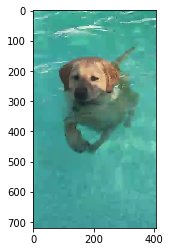

In [62]:
# Cutest doggo:

most_liked = merged.iloc[merged['favorite_count'].idxmax()]

print(most_liked['tweet_text'])
print("Liked " + str(int(most_liked['favorite_count'])) + " Times")

image = io.imread(most_liked['image_url'])
plt.imshow(image)
plt.show()

Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) 
Retweeted 74530 Times


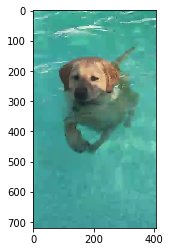

In [63]:
# Most shared doggo:

most_retweeted = merged.iloc[merged['retweet_count'].idxmax()]

print(most_retweeted['tweet_text'])
print("Retweeted " + str(int(most_retweeted['retweet_count'])) + " Times")

image = io.imread(most_retweeted['image_url'])
plt.imshow(image)
plt.show()

I guess the people that like are the same that share huh.. what did I expect

Text(0, 0.5, 'Count')

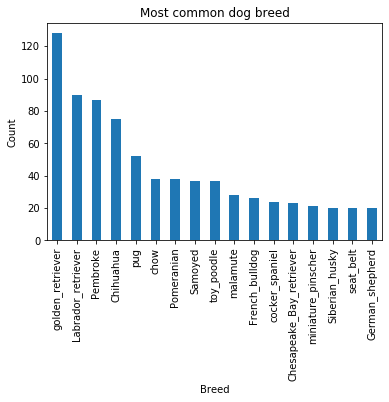

In [64]:
# Most common dog type: golden_retriever!

filtered = merged.groupby('predicted_dog_type').filter(lambda x: len(x) >= 20)

filtered['predicted_dog_type'].value_counts().plot(kind = 'bar')
plt.title('Most common dog breed')
plt.xlabel('Breed')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

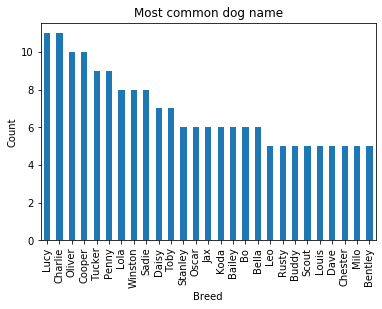

In [65]:
# Most common dog name: Lucy!

filtered = merged.groupby('dog_name').filter(lambda x: len(x) > 4)

filtered['dog_name'].value_counts().plot(kind = 'bar')
plt.title('Most common dog name')
plt.xlabel('Breed')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

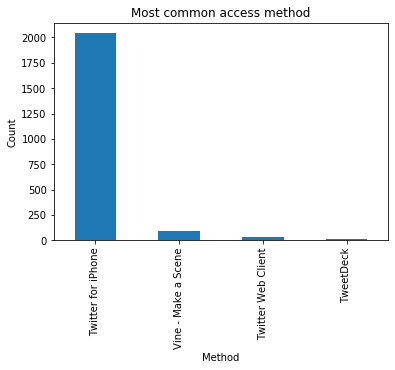

In [66]:
# Most common way to access twitter: Iphone ugh... :(

merged['source'].value_counts().plot(kind = 'bar')
plt.title('Most common access method')
plt.xlabel('Method')
plt.ylabel('Count')

This is Atticus. He's quite simply America af. 1776/10 


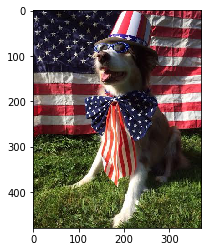

In [67]:
# WeRateDogs®'s highest rated dog

WeRate = merged.loc[merged['rating_numerator'].idxmax()]

print(WeRate['tweet_text'])

image = io.imread(WeRate['image_url'])
plt.imshow(image)
plt.show()

Text(0.5, 1.0, 'Favourite Counts vs Retweet Plot')

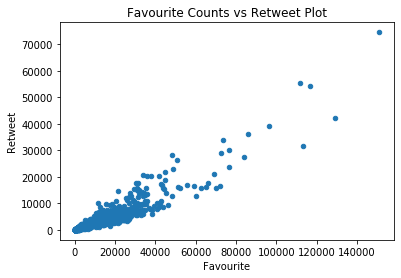

In [68]:
#Likes vs retweets seems like a linear equation where favourites are ~2 * retweets

merged.plot(x='favorite_count', y='retweet_count', kind='scatter')
plt.xlabel('Favourite')
plt.ylabel('Retweet')
plt.title('Favourite Counts vs Retweet Plot')

In [69]:
#For every retweet there are ~3 favourites (The box isn't a square that's why it's not 2 *)

print(merged['favorite_count'].sum()/merged['retweet_count'].sum())

3.3534668606638265


In [70]:
#The average prediction confidence is quite low

print("Average confidence : " + str(merged['confidence_level'].mean()))

Average confidence : 0.5938352464730294


In [71]:
#The most confident prediction isn't a dog 26% of the time.

merged['is_dog'].value_counts()

True     1425
False     503
Name: is_dog, dtype: int64

In [72]:
#Some averages

print("Average Favs : " + str(int(merged['favorite_count'].mean())))
print("Average Retweets : " + str(int(merged['retweet_count'].mean())))

Average Favs : 7877
Average Retweets : 2349
